In [1]:
# sliding window GRU with updated preprocessing and stratified splits
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('stopwords')
# Load and preprocess data
SEED = 42
np.random.seed(SEED)
df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Claudia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]

In [7]:
# Dynamically downsample overly dominant genres
threshold = 0.3 * len(df)  # e.g., no class should take more than 30% of the data
balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

In [8]:
# Tokenization
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

In [9]:
# Create sliding windows
def create_sliding_windows(seq, window_size=100, step_size=50):
    windows = []
    for start in range(0, len(seq) - window_size + 1, step_size):
        windows.append(seq[start:start+window_size])
    if not windows and len(seq) > 0:
        windows.append(seq[:window_size])
    return windows

In [11]:
X_seq = []
y_seq = []
labels = df['genre'].tolist()
tokenized_seqs = tokenizer.texts_to_sequences(df['cleaned_lyrics'])

for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    for window in windows:
        padded = pad_sequences([window], maxlen=100)[0]
        X_seq.append(padded)
        y_seq.append(labels[i])

X = np.array(X_seq)
le = LabelEncoder()
y_labels = le.fit_transform(y_seq)
y = to_categorical(y_labels)

embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [12]:
# Metadata features
meta_features = ['duration','tempo','key','loudness'] + [
    f'pitch_mean_{i}' for i in range(12)
] + [f'pitch_std_{i}' for i in range(12)] + [f'timbre_mean_{i}' for i in range(12)] + [f'timbre_std_{i}' for i in range(12)]
df[meta_features] = df[meta_features].fillna(0)
scaler = StandardScaler()
# Expand metadata to align with sliding windows
meta_rows = []
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    num_windows = len(windows)
    meta_row = df.iloc[i][meta_features].values
    for _ in range(num_windows):
        meta_rows.append(meta_row)

X_meta_all = np.array(meta_rows)
X_meta_all = scaler.fit_transform(X_meta_all)

In [13]:
# Split
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X, X_meta_all, y, y_labels, test_size=0.3, stratify=y_labels, random_state=SEED
)

X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=0.5, stratify=y_temp_labels, random_state=SEED
)

# Build and train model
input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
              weights=[embedding_matrix], trainable=False)(input_lyrics)
x = Bidirectional(GRU(64))(x)
x = Dropout(0.3)(x)

input_meta = Input(shape=(X_train_meta.shape[1],))
combined = Concatenate()([x, input_meta])
output = Dense(y.shape[1], activation='softmax')(combined)

In [14]:
model = Model(inputs=[input_lyrics, input_meta], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.fit([X_train_lyrics, X_train_meta], y_train,
          validation_data=([X_val_lyrics, X_val_meta], y_val),
          batch_size=64, epochs=20, callbacks=[early], verbose=1)

# Evaluate
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
y_true = y_test_labels

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1593 - loss: 2.7002 - val_accuracy: 0.3433 - val_loss: 2.2151
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3500 - loss: 2.1711 - val_accuracy: 0.4179 - val_loss: 2.0197
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4560 - loss: 1.9679 - val_accuracy: 0.4428 - val_loss: 1.8956
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4492 - loss: 1.8685 - val_accuracy: 0.4726 - val_loss: 1.8111
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5010 - loss: 1.7104 - val_accuracy: 0.4776 - val_loss: 1.7614
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4945 - loss: 1.6977 - val_accuracy: 0.4726 - val_loss: 1.7176
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5302 - loss: 1.6157 - val_accuracy: 0.4925 - val_loss: 1.6890
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5365 - loss: 1.5413 - val_accuracy: 0.5075 - v


Test Accuracy: 0.5693069306930693

Classification Report:
              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00         7
     Country       0.27      0.20      0.23        15
  Electronic       0.00      0.00      0.00         4
       Metal       0.43      0.33      0.38         9
  Metal Rock       0.00      0.00      0.00         3
         Pop       0.80      0.24      0.36        17
    Pop Rock       0.00      0.00      0.00         3
        Punk       0.00      0.00      0.00         4
         Rap       0.78      0.97      0.87        60
      Reggae       0.00      0.00      0.00         6
         RnB       0.00      0.00      0.00         8
        Rock       0.45      0.92      0.60        49
  Rock Metal       1.00      0.25      0.40         8
    Rock Pop       0.00      0.00      0.00         5
   Rock Punk       0.00      0.00      0.00         4

    accuracy                           0.57       202
   macro avg       0.

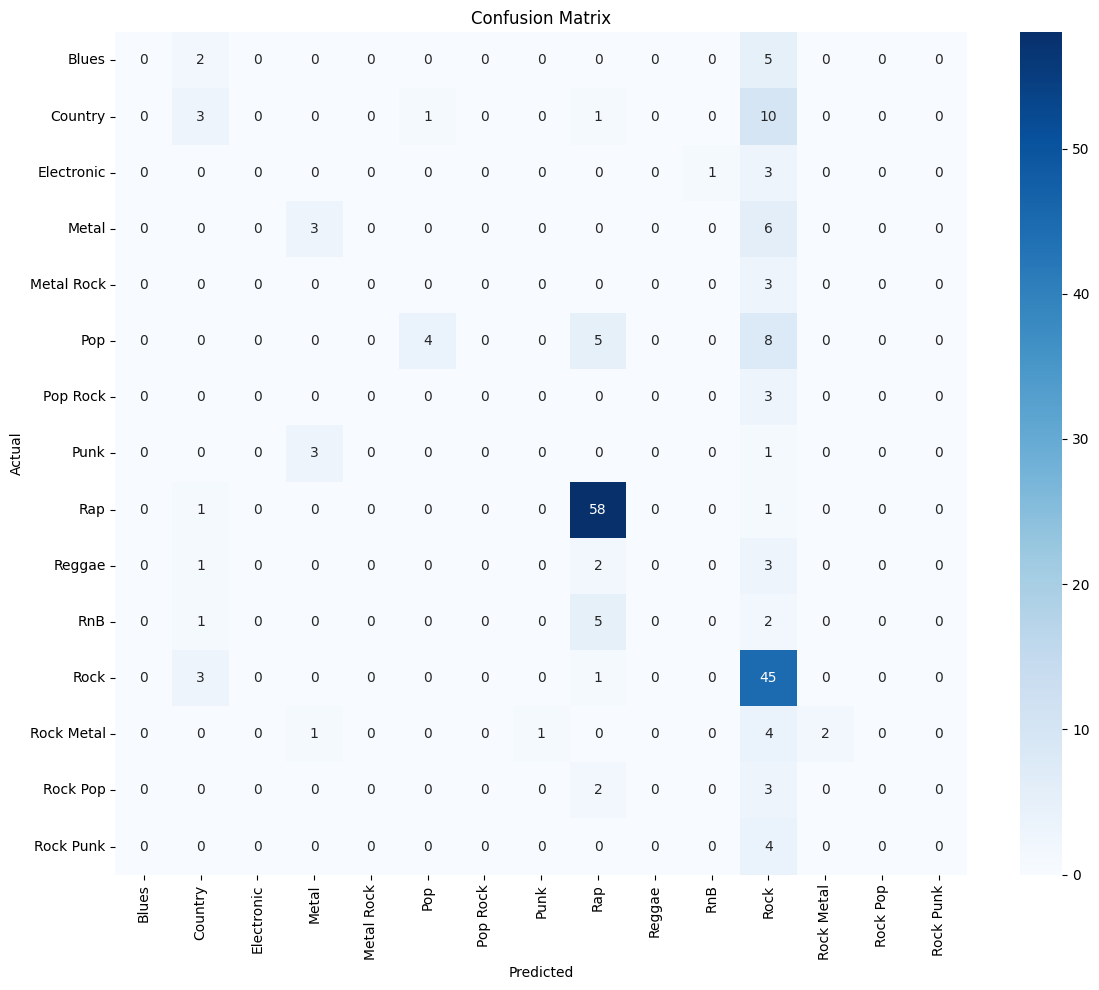

In [15]:
print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()